# Airplane Wildlife Dataset Exploratory Data Analysis
## Spring 2024 Data Science Project
### By James Zhang (118843940) and Vijaykaarti Sundarapandiyan (118748238)

# Introduction

In this analysis, we dive into the issue of airplane wildlife strikes, a phenomenon where wildlife, usually but not limited to, birds, collide with an airplane during takeoff, landing, or cruising. This topic is of paramount important since it has implications in both aviation (human) safety as well as wildlife (animal) conservation. Our questions, based on wildlife strike data from the early 1990s to present day, aim to understand patterns and thereby the underlying mechanisms behind airlife strikes. For example, we would like to answer: What times of the day (or month) are strikes most frequent? Which airplane factors most greatly influence wildlife strikes? Based on the data, what is a logical plan to minimize these strikes? By addressing these questions and compiling mitigiation plans, data scientists such as ourselves can help reduce the incidence of wildlife strikes, improving passenger safety (since wildlife strikes are one core of aircraft engine failure) , aiding wildlife conservation efforts and minimizing financial loss. While this is a self contained classroom experiment, in the real world, data scientists could use methods similar to ours based on the same data to advise airports, wildlife conservation bodies, and general authorities to have real-world impact.






In [ ]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
from sklearn import tree
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA
import warnings
warnings.filterwarnings("ignore")

# Data Curation
We want to use the following dataset about Aircraft Wildlife Strikes. Since both of us love wildlife
and hate to see horrible accidents like the ones described in the dataset, our motivational goal
is to try and learn more about the details of these accidents. Furthermore, the dataset is rather
large, giving us lots of data to play with. It has over 288,000 rows and 100 columns. From a
technical standpoint, we want to use data science techniques to learn more about where, why,
and how these accidents happen, and we can do this through explanatory statistics, data
visualization, basic neural networks models, dimensionality reduction, regressions, clustering,
and more


Before any machine learning models or statistical tests, let us first get a feel for our dataset by conducting some basic data preprocessing, which includes identifying useful characteristics and converting features to appropriate types.

In [ ]:
df = pd.read_csv("data.csv")
# Immediately drop duplicates, if there are any.
df = df.drop_duplicates()
# Additionally, we know will be working with the the TIME_OF_DAY, TIME, SIZE columns, so drop rows without all three of these values
df = df.dropna(subset=["TIME", "TIME_OF_DAY", "SIZE"])
# display a quick preview of our dataset
display(df.head())
f'There are {df.shape[0]} rows and {df.shape[1]} columns'

,INDEX_NR,INCIDENT_DATE,INCIDENT_MONTH,INCIDENT_YEAR,TIME,TIME_OF_DAY,AIRPORT_ID,AIRPORT,LATITUDE,LONGITUDE,...,SIZE,NR_INJURIES,NR_FATALITIES,COMMENTS,REPORTED_NAME,REPORTED_TITLE,SOURCE,PERSON,LUPDATE,TRANSFER
10,608253,8/7/1990,8,1990,20:25,Night,KSTL,LAMBERT-ST LOUIS INTL,38.74769,-90.35999,...,Large,NaN,NaN,OPER = DOUG HANN (3/1/12 UPDATED ID) /Legacy R...,REDACTED,REDACTED,FAA Form 5200-7,NaN,3/1/2012,False
45,608290,8/5/1990,8,1990,19:05,Day,KBWI,BALTIMORE/WASH INTL THURGOOD MARSHAL ARPT,39.17540,-76.66820,...,Small,NaN,NaN,/Legacy Record=100049/,REDACTED,REDACTED,FAA Form 5200-7,NaN,2/10/1999,False
64,608314,10/31/1990,10,1990,08:08,Day,KEWR,NEWARK LIBERTY INTL ARPT,40.69250,-74.16866,...,Medium,NaN,NaN,A/C REG REPTD AS N744 INCORRECT /Legacy Record...,REDACTED,REDACTED,FAA Form 5200-7,Tower,12/18/1998,False
122,608388,4/17/1991,4,1991,13:15,Day,KDCA,RONALD REAGAN WASHINGTON NATIONAL ARPT,38.85208,-77.03772,...,Medium,NaN,NaN,/Legacy Record=100147/,REDACTED,REDACTED,FAA Form 5200-7,Tower,12/19/2003,False
136,608407,10/15/1990,10,1990,10:07,Night,KTRI,TRI-CITIES REGIONAL TN/VA ARPT,36.47521,-82.40742,...,Medium,NaN,NaN,/Legacy Record=100166/,REDACTED,REDACTED,FAA Form 5200-7,NaN,12/4/1998,False


'There are 112209 rows and 100 columns'

Our dataset has $288, 810$ rows/entries and $100$ columns/features. $100$ features gives us lots of options to choose from when it comes to feature selection, machine learning models, regressions, and hypothesis tests. To get more information about each feature, we can use `df.info()` to find out some basic information like the Non-Null Count and datatype.

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 112209 entries, 10 to 288808
Data columns (total 100 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   INDEX_NR               112209 non-null  int64  
 1   INCIDENT_DATE          112209 non-null  object 
 2   INCIDENT_MONTH         112209 non-null  int64  
 3   INCIDENT_YEAR          112209 non-null  int64  
 4   TIME                   112209 non-null  object 
 5   TIME_OF_DAY            112209 non-null  object 
 6   AIRPORT_ID             112208 non-null  object 
 7   AIRPORT                112209 non-null  object 
 8   LATITUDE               107376 non-null  float64
 9   LONGITUDE              107375 non-null  float64
 10  RUNWAY                 98432 non-null   object 
 11  STATE                  107376 non-null  object 
 12  FAAREGION              107376 non-null  object 
 13  LOCATION               4516 non-null    object 
 14  ENROUTE_STATE          3093 non-null   

On a high level, our features can be categorized in the following manner:
- Time `(INCIDENT_DATE, TIME, TIME_OF_DAY)`
- Metadata `(SOURCE, INDEX_NR, AIRPORT)`
- Physics-related `(AC_MASS, HEIGHT, SPEED, DISTANCE)`
- Species-related `(SPECIES, SPECIES_ID, REMAINS_COLLECTED, NR_INJURIES)`
- Money-related `(COST_REPAIRS, COST_REPAIRS_INFL_ADJ, COST_OTHER)`
- Categorical `(WARNED, SKY, AIRCRAFT)`
- Boolean `(DAM_RAD, DAM_WINDSHIELD, STR_ENG1)`

Once more, there is more than sufficent data collected in this dataset. Furthermore, the owners of the dataset have done a pretty good job of converting columns to the appropriate datatypes, ie. to float and string when needed. The only additional needed preprocessing is with respect to the time-related columns. Conversion for the `INCIDENT_DATE` column to `pd.datetime` is trivial. The `TIME` column required a little bit more effort, however. There were some errors in the data such as NaN values and minute recordings between greater than $60$, which doesn't make sense. See our implementation below.

In [ ]:
def time_helper(x):
    # If nan, then just return nan.
    if isinstance(x, float):
        return np.NaN
    # We want at least hour and minute precision.
    elements = str(x).split(':')
    if len(elements) < 2:
        return np.NaN
    # Ensure validity of hours and minutes before returning.
    h, m = int(elements[0]), int(elements[1])
    return x if h in range(0, 25) and m in range(0, 61) else np.NaN

df["TIME"] = df["TIME"].apply(time_helper)
df = df.dropna(subset=["TIME"])
df["TIME"] = pd.to_datetime(df["TIME"], format="%H:%M", errors="coerce")
df = df.dropna(subset=["TIME"])

#preview
df

,INDEX_NR,INCIDENT_DATE,INCIDENT_MONTH,INCIDENT_YEAR,TIME,TIME_OF_DAY,AIRPORT_ID,AIRPORT,LATITUDE,LONGITUDE,...,SIZE,NR_INJURIES,NR_FATALITIES,COMMENTS,REPORTED_NAME,REPORTED_TITLE,SOURCE,PERSON,LUPDATE,TRANSFER
10,608253,8/7/1990,8,1990,1900-01-01 20:25:00,Night,KSTL,LAMBERT-ST LOUIS INTL,38.74769,-90.35999,...,Large,NaN,NaN,OPER = DOUG HANN (3/1/12 UPDATED ID) /Legacy R...,REDACTED,REDACTED,FAA Form 5200-7,NaN,3/1/2012,False
45,608290,8/5/1990,8,1990,1900-01-01 19:05:00,Day,KBWI,BALTIMORE/WASH INTL THURGOOD MARSHAL ARPT,39.17540,-76.66820,...,Small,NaN,NaN,/Legacy Record=100049/,REDACTED,REDACTED,FAA Form 5200-7,NaN,2/10/1999,False
64,608314,10/31/1990,10,1990,1900-01-01 08:08:00,Day,KEWR,NEWARK LIBERTY INTL ARPT,40.69250,-74.16866,...,Medium,NaN,NaN,A/C REG REPTD AS N744 INCORRECT /Legacy Record...,REDACTED,REDACTED,FAA Form 5200-7,Tower,12/18/1998,False
122,608388,4/17/1991,4,1991,1900-01-01 13:15:00,Day,KDCA,RONALD REAGAN WASHINGTON NATIONAL ARPT,38.85208,-77.03772,...,Medium,NaN,NaN,/Legacy Record=100147/,REDACTED,REDACTED,FAA Form 5200-7,Tower,12/19/2003,False
136,608407,10/15/1990,10,1990,1900-01-01 10:07:00,Night,KTRI,TRI-CITIES REGIONAL TN/VA ARPT,36.47521,-82.40742,...,Medium,NaN,NaN,/Legacy Record=100166/,REDACTED,REDACTED,FAA Form 5200-7,NaN,12/4/1998,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
288795,1472236,8/28/2023,8,2023,1900-01-01 23:20:00,Night,KRSW,SOUTHWEST FLORIDA INTL ARPT,26.53617,-81.75517,...,Small,NaN,NaN,NaN,REDACTED,REDACTED,FAA Form 5200-7-E,Airport Operations,11/17/2023,False
288798,1472241,8/28/2023,8,2023,1900-01-01 11:25:00,Night,KSMF,SACRAMENTO INTL,38.69542,-121.59077,...,Medium,NaN,NaN,NaN,REDACTED,REDACTED,FAA Form 5200-7-E,Pilot,11/17/2023,False
288804,1472251,8/28/2023,8,2023,1900-01-01 23:00:00,Night,KDEN,DENVER INTL AIRPORT,39.85841,-104.66700,...,Small,NaN,NaN,NaN,REDACTED,REDACTED,FAA Form 5200-7-E,Pilot,11/17/2023,False
288807,1472257,8/28/2023,8,2023,1900-01-01 07:14:00,Dusk,KDTW,DETROIT METRO WAYNE COUNTY ARPT,42.21206,-83.34884,...,Small,NaN,NaN,NaN,REDACTED,REDACTED,FAA Form 5200-7-E,Airport Operations,11/17/2023,False


We can also print out some summary statistics for each of our numerical columns using the `df.describe()` method. Note that some of these entries are meaningless; for example, the standard deviation of the Latitude column holds no weight. On the other hand, some entries such as the mean speed of the airplane can be useful for later analysis, but this representation is overall pleasant and informational.

In [ ]:
df.describe()

,INDEX_NR,INCIDENT_MONTH,INCIDENT_YEAR,TIME,LATITUDE,LONGITUDE,EMA,EMO,AC_MASS,NUM_ENGS,...,ENG_2_POS,ENG_3_POS,ENG_4_POS,HEIGHT,SPEED,DISTANCE,AOS,BIRD_BAND_NUMBER,NR_INJURIES,NR_FATALITIES
count,1.120200e+05,112020.000000,112020.000000,112020,1.071930e+05,107192.000000,102248.000000,99344.000000,109718.000000,109573.000000,...,100861.000000,6214.000000,1279.000000,96189.000000,62174.000000,73452.000000,9395.000000,1.330000e+02,170.000000,17.000000
mean,8.784088e+05,7.210909,2012.797358,1900-01-01 13:43:56.228709120,4.252592e+02,-89.575588,19.023707,8.074177,3.488489,1.995939,...,2.761841,2.534438,2.433933,803.796141,141.359443,1.400340,94.398225,7.017296e+07,1.317647,2.352941
min,6.082530e+05,1.000000,1990.000000,1900-01-01 00:00:00,-3.483842e+01,-177.381000,0.000000,0.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,1.000000,1.000000
25%,7.033778e+05,5.000000,2008.000000,1900-01-01 09:00:00,3.336996e+01,-98.469780,10.000000,1.000000,3.000000,2.000000,...,1.000000,1.000000,1.000000,0.000000,120.000000,0.000000,1.000000,0.000000e+00,1.000000,1.000000
50%,7.638295e+05,8.000000,2014.000000,1900-01-01 13:22:00,3.869542e+01,-87.896580,22.000000,4.000000,4.000000,2.000000,...,1.000000,1.000000,1.000000,30.000000,139.000000,0.000000,3.000000,0.000000e+00,1.000000,2.000000
75%,1.063895e+06,9.000000,2018.000000,1900-01-01 19:00:00,4.078839e+01,-80.290560,23.000000,10.000000,4.000000,2.000000,...,5.000000,5.000000,4.000000,800.000000,160.000000,0.000000,24.000000,1.807804e+08,1.000000,3.000000
max,1.472258e+06,12.000000,2023.000000,1900-01-01 23:59:00,4.115443e+07,164140.000000,92.000000,2301.000000,5.000000,4.000000,...,7.000000,6.000000,5.000000,30000.000000,1250.000000,99.000000,10080.000000,2.811782e+08,7.000000,8.000000
std,2.479049e+05,2.763267,6.570082,NaN,1.257083e+05,502.331572,10.587937,13.354216,0.889417,0.405165,...,1.998701,1.882520,1.499652,1729.502656,46.108955,4.489294,420.063573,8.849556e+07,0.772482,1.868863


# Exploratory Data Analysis

Now, we'll move on to exploring actual features of the data, since now we've cleaned the data (at least, the relevant columns), with three statistical analyses themselves each accompanied by three graphs.

In [ ]:
df["TIME"]

10       1900-01-01 20:25:00
45       1900-01-01 19:05:00
64       1900-01-01 08:08:00
122      1900-01-01 13:15:00
136      1900-01-01 10:07:00
                 ...        
288795   1900-01-01 23:20:00
288798   1900-01-01 11:25:00
288804   1900-01-01 23:00:00
288807   1900-01-01 07:14:00
288808   1900-01-01 09:00:00
Name: TIME, Length: 112020, dtype: datetime64[ns]

## Method #1: Exploring Time Distribution

Here, we'll convert the Time column into a numerical format and observe summary statistics for these values, and we'll plot the results in a boxplot



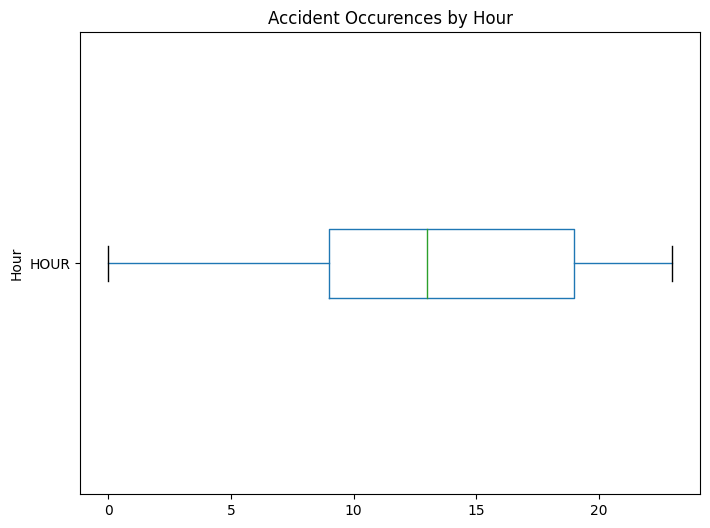

In [ ]:
df["HOUR"] = df["TIME"].dt.hour
summary_stats = df["HOUR"].describe()

plt.figure(figsize = (8, 6))
df.boxplot(column = "HOUR", vert=False)
plt.title("Accident Occurences by Hour")
plt.ylabel("Hour")
plt.grid(False)
plt.show()

Analyzing the sideways box plot of accident occurrences by hour, we can extract a few important bits of information. First, there are no outliers, which makes sense because flights and therefore accidents can occur at any hour of the day. The whiskers extend to show the full range of data, with the left whisker being at $0 (12am)$ and the right whisker being at $23$ $(11pm)$ as desired. There exists a slight rightwards skew in the data. Most airplane wildlife crashes occur between the early morning and mid to late afternoon (dusk), which is interesting, but one important thing to note is that these are wildlife crashes. One might hypothesize that planes are most likely to crash when it is dark, however most animals are not flying that high in the sky in the dark, which could explain this distribution in the data, but more tests and information will need to be collected in order to back this hypothesis.

## Method #2: Testing the Effect of Time of Day and the Number of Accidents.

Here, we'll see if there is any relation between the time of day and the number of accidents occuring. We will perform a chi-square hypothesis test based on the actual frequency of different time of day accidents and the expected frequency of the accidents based on the size of the data set.

H0: The time of day has no effect on the probability of an accident occuring
HA: The time of day has an effect on the probability of an accident occuring


0.0


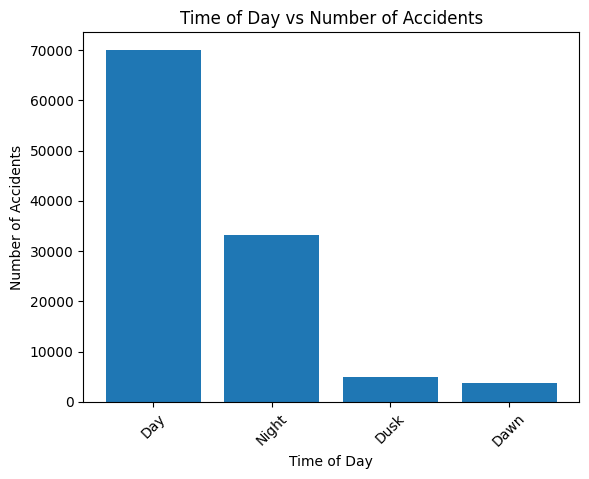

In [ ]:
observed_frequencies = df["TIME_OF_DAY"].value_counts()
expected_frequences = len(df) / len(observed_frequencies)

# We then perform the actual test
_, p_value = stats.chisquare(observed_frequencies, expected_frequences)

print(p_value)

plt.bar(observed_frequencies.index, observed_frequencies)
plt.xlabel('Time of Day')
plt.ylabel('Number of Accidents')
plt.title('Time of Day vs Number of Accidents')
plt.xticks(rotation=45)
plt.show()

Because our p-value is approximately 0.0 (it is so small it has been rounded) which is less than our determined alpha of 0.05, we reject the null hypothesis and deduce that indeed, the time of day, which according to our bar chart is Night, has an effect on the probability of an accident occurring

## Method #3: Testing the Number of Accidents by Incident Year

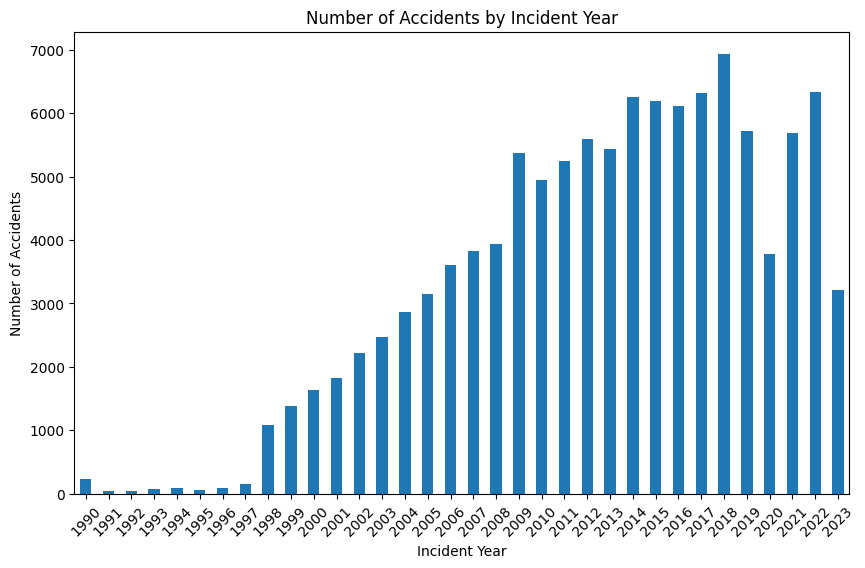

In [ ]:
# Groupby incident year.
accidents_per_year = df.groupby('INCIDENT_YEAR').apply(len)

# Define a matplotlib figure bar chart.
plt.figure(figsize=(10, 6))
accidents_per_year.plot(kind='bar')
plt.title('Number of Accidents by Incident Year')
plt.xlabel('Incident Year')
plt.ylabel('Number of Accidents')
plt.xticks(rotation=45)
plt.show()

Note that there was a steady increase in airplane wildlife crashes in the past 30 years, however this might be due to better accident tracking technology and not due to a decrease in airline flying safety. In conclusion, without additional research, it is temporarily to early to draw meaningful takeaways. However, this EDA is a good start to get familiarized with our dataset. Furthermore, there is a significant amount of data being recorded. Thus, we have sufficient data to try to perform some ML models, such as SVM, basic regressions, or simple classifications.

# Primary Analysis

## Classifying Damage Levels

In the following section, the goal is to correctly classify the damage level of an accident, as described by the `DAMAGE_LEVEL` column. Note that this is a generic classification task. Consider the class distribution using the `value_counts()` function below.

In [ ]:
df["DAMAGE_LEVEL"].value_counts()

DAMAGE_LEVEL
N     89863
M      3967
M?     3966
S      2250
D        63
Name: count, dtype: int64

According to the Kaggle Dataset documentation, the classes are defined as the following
- "N" -> No Damage
- "M" -> Minor Damage
- "M?" -> Moderate Damage
- "S" -> Significant Damage
- "D" -> Destruction

In general, an accident with a higher damage classification should have a higher cost of repairs, so let's perform a quick sanity check to verify the validity of the above classes. First, we must preprocess the cost of repairs column, and then we can use `groupby` to do our check. Below, note that the higher the damage level, the higher the average inflation adjusted cost of repairs, which is what we expect.

In [ ]:
def cost_helper(cost) -> float:
    if pd.isnull(cost):
        return 0.0
    if isinstance(cost, float):
        return cost
    if isinstance(cost, str):
        return float(cost.replace(',', ''))

df["COST_REPAIRS_INFL_ADJ"] = df["COST_REPAIRS_INFL_ADJ"].apply(cost_helper)
df.groupby("DAMAGE_LEVEL")["COST_REPAIRS_INFL_ADJ"].mean()

DAMAGE_LEVEL
D     1.441470e+06
M     8.757379e+03
M?    1.955610e+04
N     0.000000e+00
S     2.323795e+05
Name: COST_REPAIRS_INFL_ADJ, dtype: float64

Our dataset has a plethora of features - $100$ to be precise. Thus, feature selection is imperative for our model to prevent overfitting. Below, we manually drop many of the columns such as date, time, airport id, state, latitude, longitude, etc because we do not believe that they will contribute to the predictive power of the model. For example, in general, the runway probably cannot explain the cost of repairs in the case of an airplane wildlife accident. Other features, such as `NR_INJURIES` and `NR_FATALITIES` would be useful, but the elements are almost all NaN. Other features such as `STR_*` are essentially duplicates of the binary `DAM_*`, and so we drop these too. Look at the code block below for some other basic data cleaning. For columns that are categorical, we apply One-Hot Encoding using the `get_dummies()` function.

In [ ]:
drop_columns = ["INDEX_NR", "INCIDENT_DATE", "INCIDENT_YEAR", "TIME", "AIRPORT", "HOUR", "AIRPORT_ID", "RUNWAY", "STATE", "LATITUDE", "LONGITUDE", "LOCATION", "OPERATOR", "COMMENTS", "REPORTED_NAME",
                "REPORTED_TITLE", "OPID", "REG", "FLT", "AIRCRAFT", "ENROUTE_STATE", "NUM_SEEN", "SOURCE", "PERSON", "LUPDATE", "SPECIES", "SPECIES_ID", "REMARKS", "EFFECT_OTHER", "EFFECT", "OTHER_SPECIFY",
                "BIRD_BAND_NUMBER", "ING_ENG1", "ING_ENG2", "ING_ENG3", "ING_ENG4", "STR_ENG1", "STR_ENG2", "STR_ENG3", "STR_ENG4", "STR_WINDSHLD", "STR_OTHER", "STR_NOSE", "STR_TAIL", "STR_FUSE", "STR_NOSE", "STR_LG",
                "STR_PROP", "STR_LGHTS", "STR_WING_ROT", "DAM_OTHER", "TRANSFER", "AC_CLASS", "INCIDENT_MONTH", "ENG_1_POS", "ENG_2_POS", "ENG_3_POS", "ENG_4_POS",
                "NR_INJURIES", "NR_FATALITIES", "AOS", "COST_REPAIRS", "COST_OTHER", "COST_OTHER_INFL_ADJ"]

data = df.drop(columns=drop_columns)

# Replace boolean with integer values - probably doesn't change anything.
data = data.replace({False: 0, True: 1})

# Convert these features to numeric values.
convert_numerical = ["AMA", "AMO"]
for col in convert_numerical:
    data[col] = pd.to_numeric(data[col], errors='coerce').fillna(0).astype(float)

# Some entries are ranges - encode these with actual numerical values.
replace_map = {'1': 1, '2-10': 6, '11-100': 55, 'More than 100': 100}
data = data.replace(replace_map)

# Apply One-Hot Encoding
categorical_columns = list(data.select_dtypes(include=['object']).columns)
print(f'The categorical columns are {categorical_columns}.')
categorical_columns.remove('DAMAGE_LEVEL')
data = pd.get_dummies(data, columns=categorical_columns)
data = data.dropna()
data = data.reset_index().drop(columns="index")
data

The categorical columns are ['TIME_OF_DAY', 'FAAREGION', 'TYPE_ENG', 'PHASE_OF_FLIGHT', 'SKY', 'PRECIPITATION', 'DAMAGE_LEVEL', 'WARNED', 'SIZE'].


,AMA,AMO,EMA,EMO,AC_MASS,NUM_ENGS,HEIGHT,SPEED,DISTANCE,COST_REPAIRS_INFL_ADJ,...,"PRECIPITATION_None, Snow",PRECIPITATION_Rain,"PRECIPITATION_Rain, Snow",PRECIPITATION_Snow,WARNED_No,WARNED_Unknown,WARNED_Yes,SIZE_Large,SIZE_Medium,SIZE_Small
0,372.0,4.0,37.0,43.0,4.0,2.0,0.0,80.0,0.0,0.0,...,False,False,False,False,True,False,False,False,False,True
1,583.0,21.0,34.0,10.0,4.0,2.0,0.0,70.0,0.0,0.0,...,False,False,False,False,True,False,False,False,False,True
2,729.0,25.0,7.0,31.0,2.0,2.0,0.0,60.0,0.0,0.0,...,False,False,False,False,False,False,True,False,True,False
3,148.0,11.0,34.0,10.0,4.0,3.0,0.0,80.0,0.0,0.0,...,False,True,False,False,True,False,False,False,False,True
4,372.0,12.0,37.0,46.0,4.0,2.0,0.0,140.0,0.0,0.0,...,False,False,False,False,False,False,True,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34933,316.0,11.0,31.0,10.0,3.0,2.0,0.0,90.0,0.0,0.0,...,False,False,False,False,False,True,False,False,False,True
34934,226.0,49.0,46.0,1.0,2.0,2.0,2600.0,230.0,4.0,0.0,...,False,False,False,False,True,False,False,False,True,False
34935,729.0,33.0,7.0,19.0,2.0,2.0,50.0,80.0,0.0,0.0,...,False,False,False,False,True,False,False,False,False,True
34936,148.0,0.0,10.0,1.0,4.0,2.0,2000.0,210.0,2.0,0.0,...,False,False,False,False,False,True,False,False,False,True


After further cleaning our data, our dataset now has $35,941$ rows and $83$ features, which is slightly smaller than what we originally had, but we are not ready to tackle our classification task. We will apply $3$ models: KNearestNeighbors, Random Forest, and a Neural Network. The first two can easily be implemented using Sklearn, and we can create the simple feed forward neural network using PyTorch. All methods will use KFold Cross Validation.

In [ ]:
seed = 42
X = data.loc[:, data.columns != "DAMAGE_LEVEL"]
y = np.ravel(data["DAMAGE_LEVEL"])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

models = {
  "KNN": KNeighborsClassifier(n_neighbors=5),
  "Decision Tree": DecisionTreeClassifier(),
  "Random Forest": RandomForestClassifier()
}

k_folds = 5
skf = StratifiedKFold(n_splits=k_folds, shuffle=True, random_state=seed)

for model_name, model in models.items():
  accuracies = cross_val_score(model, X_train_scaled, y_train, cv=skf)
  model.fit(X_train_scaled, y_train)
  y_pred = model.predict(X_test_scaled)
  accuracy = accuracy_score(y_test, y_pred)
  print(f"{model_name:8}\t | CV mean={np.mean(accuracies) * 100:1}%\t | CV std={np.std(accuracies) * 100:1}%\t | Testing Accuracy={accuracy * 100}%")

KNN     	 | CV mean=94.52076611086527%	 | CV std=0.20131488643561532%	 | Testing Accuracy=94.22820072505247%
Decision Tree	 | CV mean=94.98282927592572%	 | CV std=0.05843012133036386%	 | Testing Accuracy=94.99141385231826%
Random Forest	 | CV mean=95.6574936226249%	 | CV std=0.22518437983346967%	 | Testing Accuracy=95.78324747185651%


Our results using standard classifiers are already quite good! We've printed our average accuracies and standard deviation of the accuracies across the k cross validation folds for all classifiers: KNN, Decision Trees, and Random Forest. In both our training set and testing set, performance (in terms of accuracy) is ranked as follows from most accurate to least accurate: Random Forest, Decision Tree, and then KNN.

On that note, let's try a more complex neural network to try and improve our classification accuracies for damage levels.

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from torch import optim

# Define the model's hyperparameters.
BATCH_SIZE = 16
LR = 0.00001
EPOCHS = 70
SEED = 42

# Convert our ground truth datasets from letters to numerical such that we can have a sense of "loss".
to_numerical = {'N': 0, 'M': 1, 'M?': 2, 'S': 3, 'D': 4, 0: 0, 1: 1, 2: 2, 3: 3, 4: 4}
y_train = np.vectorize(lambda x: to_numerical[x])(y_train)
y_test = np.vectorize(lambda x: to_numerical[x])(y_test)

# Define dataloaders using some handy PyTorch classes.
train_set = TensorDataset(torch.from_numpy(X_train_scaled).float(), torch.from_numpy(y_train))
test_set = TensorDataset(torch.from_numpy(X_test_scaled).float(), torch.from_numpy(y_test))
train_dataloader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=False)

Since this dataset is rather simple, a simple feed forward neural network architecture will suffice. The input has to be of length $82$ since there are $82$ features and the output layer is of length $5$ since there are $5$ damage levels. The softmax activation function is used in the last layer to convert values to probabilties, and then we choose the argument maximum to be our model output class prediction. In the next two code blocks, we define the NN class as a subclass of the PyTorch `nn.Module` and then implement a simple training loop. See the Visualization section for a plot of our loss values decreasing.

In [ ]:
class NN(nn.Module):

    def __init__(self):
        super(NN, self).__init__()
        # Define a simple feed-forward architecture with linear layers and ReLU activation functions.
        self.layers = nn.Sequential(
            nn.Linear(81, 100),
            nn.ReLU(),
            nn.Linear(100, 75),
            nn.ReLU(),
            nn.Linear(75, 10),
            nn.ReLU(),
            nn.Linear(10, 5)
        )

    def forward(self, X):
        out = self.layers(X)
        # At the end, apply softmax to obtain probabilities required for multi-class classification.
        return F.log_softmax(out, dim=1)

In [ ]:
# Define the neural network and the ADAM optimizer.
model = NN()
optimizer = optim.Adam(model.parameters(), lr=LR)
train_loss = []

# Training loop, using the negative log likelihood loss function.
for epoch in range(EPOCHS):
    model.train()
    train_loss_per_epoch = []
    for idx, (x, y) in enumerate(train_dataloader):
        optimizer.zero_grad()
        yhat = model.forward(x)
        loss = F.nll_loss(yhat, y)
        loss.backward()
        optimizer.step()
        train_loss_per_epoch.append(loss.item())

    train_loss.append(np.mean(train_loss_per_epoch))

    # Print our average training loss after every 5 epochs.
    if epoch % 5 == 0:
        print(f"Epoch: {epoch}, Train Loss: {np.mean(train_loss)}")

Epoch: 0, Train Loss: 1.3364331888326093
Epoch: 5, Train Loss: 0.5946800215167757
Epoch: 10, Train Loss: 0.406674252622198
Epoch: 15, Train Loss: 0.3265867466824376
Epoch: 20, Train Loss: 0.28105739010947184
Epoch: 25, Train Loss: 0.250785283419419
Epoch: 30, Train Loss: 0.2287025210351376
Epoch: 35, Train Loss: 0.21162614159268828
Epoch: 40, Train Loss: 0.197990362592929
Epoch: 45, Train Loss: 0.18689201552000193
Epoch: 50, Train Loss: 0.17770373794315245
Epoch: 55, Train Loss: 0.16997655578070775
Epoch: 60, Train Loss: 0.16337377345709275
Epoch: 65, Train Loss: 0.15765260658304253


Now to test our neural network, we set the model to evaluation mode, and run it on the test set! Our accuracy turns out to be around $95.55$%, which is slightly below the random forest accuracy levels, but not by much!

In [ ]:
model.eval()
test_loss = 0
correct = 0
with torch.no_grad():
    for x, y in test_dataloader:
        output = model(x)
        test_loss += F.nll_loss(output, y, reduction='sum').item()
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(y.view_as(pred)).sum().item()

test_loss /= len(test_dataloader.dataset)

print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({}%)\n'.format(test_loss, correct, len(test_dataloader.dataset), 100. * correct / len(test_dataloader.dataset)))


Test set: Average loss: 0.0965, Accuracy: 10008/10482 (95.4779622209502%)



# Visualization

[[-0.82140156 -0.89199676]
 [ 0.4174105  -1.21365514]
 [-0.71649651  1.90380019]
 ...
 [ 0.06259293 -0.95048463]
 [ 4.02863786  2.63986305]
 [-1.53903375  0.91904137]] (24456, 2)


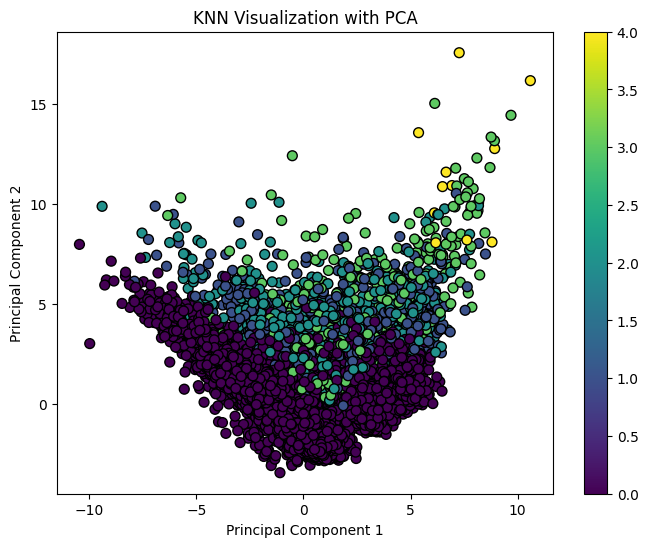

In [ ]:
# For KNN, we use PCA to reduce dimensions to 2D for visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_train_scaled)

print(X_pca, X_pca.shape)

# Scatter plot for KNN
plt.figure(figsize=(8, 6))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_train, cmap='viridis', edgecolor='k', s=50)
plt.title('KNN Visualization with PCA')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(scatter)
plt.show()

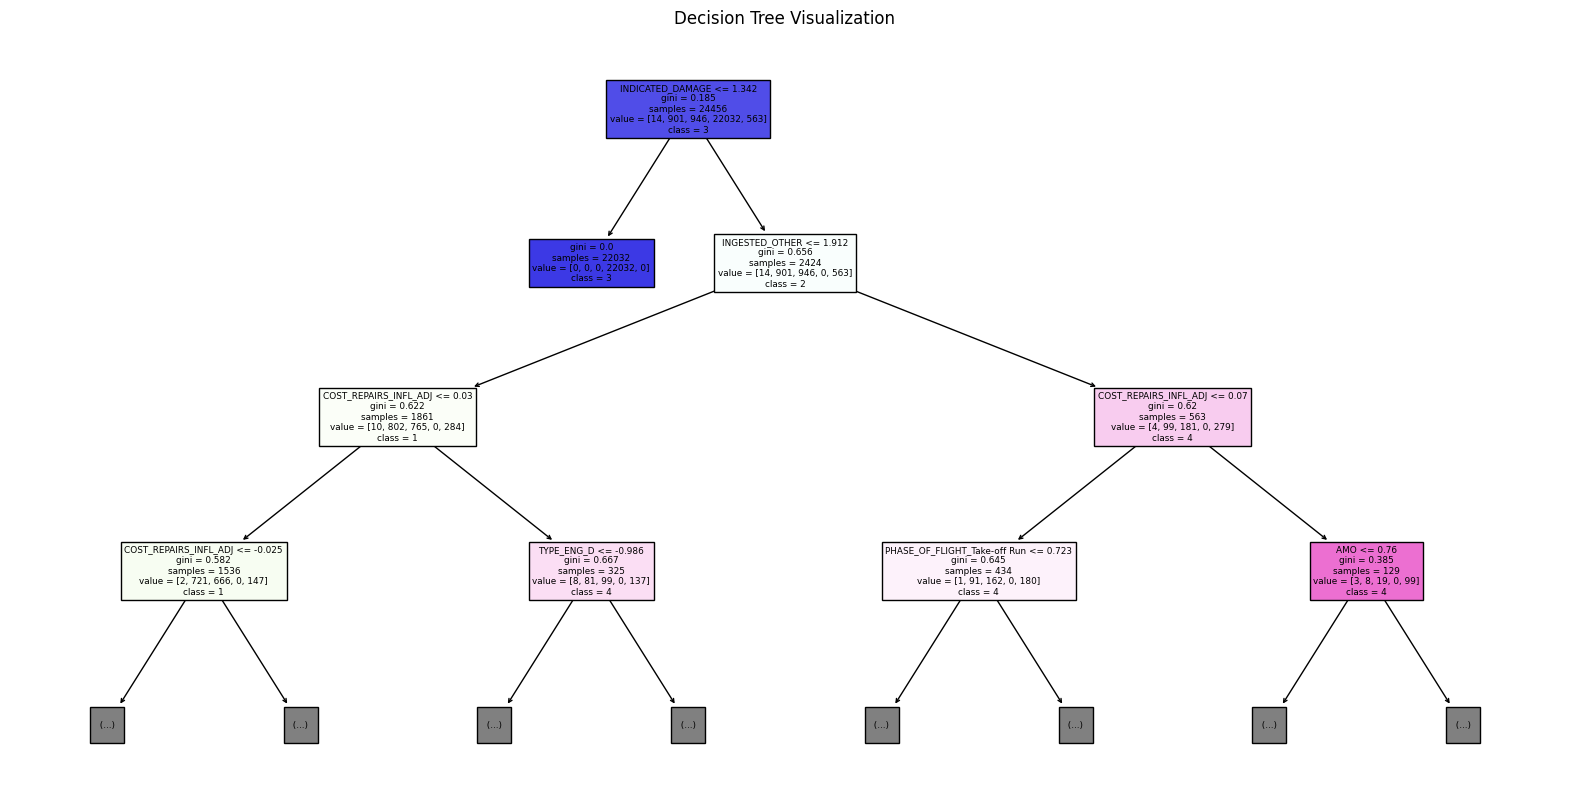

In [ ]:
# Visualize Decision Tree
plt.figure(figsize=(20,10))
tree.plot_tree(models['Decision Tree'], filled=True, feature_names=X.columns, class_names=np.unique(y_train).astype(str), max_depth=3)
plt.title('Decision Tree Visualization')
plt.show()

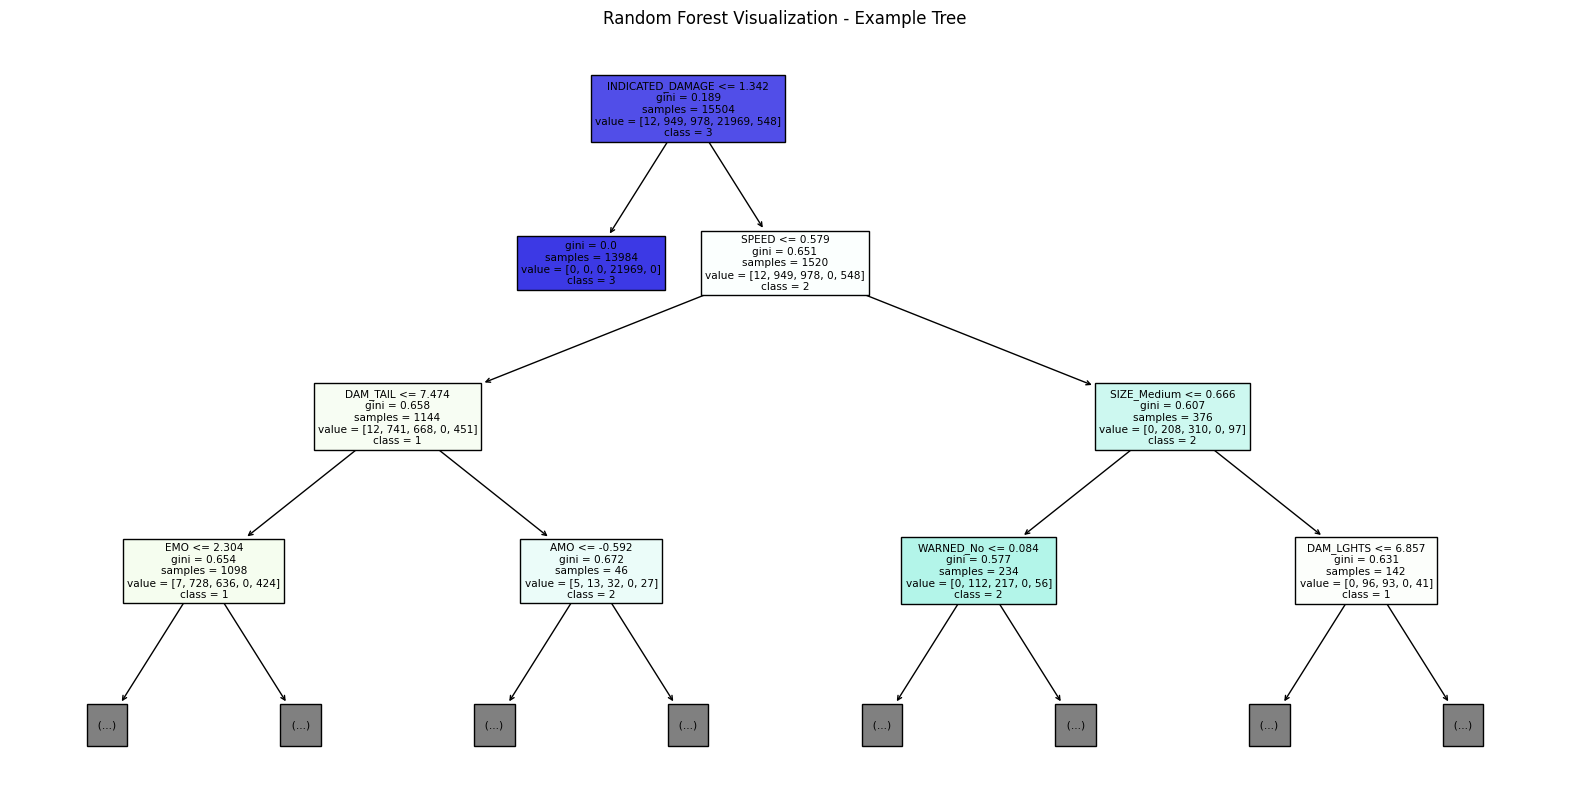

In [ ]:
# Visualize Random Forest (showing only one tree for simplicity)
plt.figure(figsize=(20,10))
rf_tree = models['Random Forest'].estimators_[0]
tree.plot_tree(rf_tree, filled=True, feature_names=X.columns, class_names=np.unique(y_train).astype(str), max_depth=3)
plt.title('Random Forest Visualization - Example Tree')
plt.show()

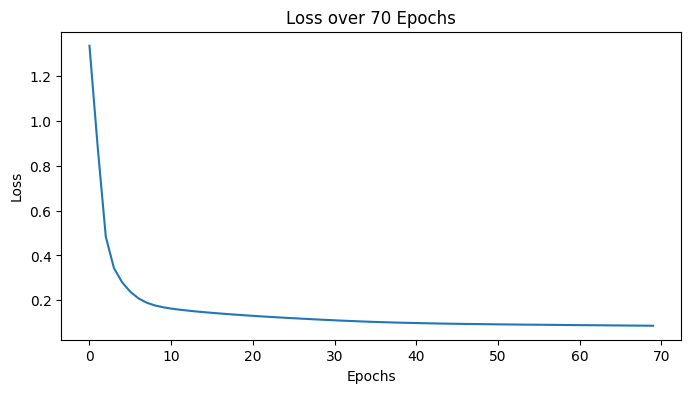

In [ ]:
plt.figure(figsize=(8,4))
plt.plot(train_loss)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title(f"Loss over {EPOCHS} Epochs")
plt.show()

# Insights and Conclusions

In this portion, we analyze our results and state a select few important observations, plausible explanations, as well as recommended policy decisions.

- Firstly, we notice that the plurality of wildlife strike incidents occur during the day, as opposed to night, dusk, and dawn. This observation makes sense, since most birds and flight-capable mammals are diurnal (note: flight capable is important here since the majority of **all** mammals are noctural), meaning that they are active during the day (https://www.birds.cornell.edu/k12/do-birds-sleep/). Using loose statistics, P(airplane in the same volumetric space as an animal|day) > P(airplane in the same volumetric space as an animal|night), which purely from a dynamical systems perspective, means there is an increased chance of a collision between the two bodies during the day. Thus, a natural policy decision here would be to train pilots to recognize and avoid common bird flight formations during the day, which coincidentally is when visibility is highest.
- Secondly, we notice from our decision tree models (tree, random forest single tree examples in our primary analysis) that speed, size, engine-type, and flight phase (among many others) are greatly correlated with the damage classification for many incidents (which is why the heuristic generating the trees put them closer to the root). This means that there exists certain direct tradeoffs between cost (plane make and model) and in-flight safety that can be optimized by airplane maker, and thus as a policy decision, we recommend that airplane manufacters perform collision simulations before deciding on airplane specs i.e. perform an analysis similar to what we did and input their plausible specs as input parameters.
- Finally, we notice that our neural network (mind you, ridiculously simple feed-forward model) performs extraordinarily well, performing similar to our tree-based decision models. While training ensemble models like random forests can be tedious and resource intensive, we achieve similar performance with a much more compact model (though the inference is likely just as expensive). As a result, we recommend training a more intricate neural network to capture even more of the variation in the training data, with again, minimal space expenditure compared to other traditional ml models. Going further, theoretically tending the width of the model to infinity while increasing depth by a scaling factor as well (see https://arxiv.org/abs/2011.14522), we can achieve even better performance. As a policy recommendation, we advise conservation bodies and aviation safety bodies to train their own deep learning models based on our dataset's parameters, in addition to any other parameters they may have privately, in order to gauge and approve new airplane models with respect to in-flight collision safety.

All in all, a new reader might expect certain observations (such as specs of a plane correlating with damage) but might also be surprised (collisions occur more frequently during the day, even though flights are somewhat uniformly distributed over all parts of the day and visibility at night is lower). We hope that through walking the reader through all steps of the data science cycle, the methods behind achieving even confusing or unintuitive conclusions becomes clear. To end off, we ask a follow-up open ended question: we noticed that in our EDA that over time, flight collisions have slowly ramped up. Why is this the case, despite the fact that airplane safety measures and build quality have only increased over time.